In [31]:
# Built-in modules
import math
import qiskit_ibm_runtime

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session

In [32]:
# Save an IBM Quantum account on disk.
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="IBM Quantum API token")

In [33]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_brisbane'

In [34]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

/Users/shisheerskaushik/anaconda3/envs/qiskit/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:282: UserWarning: Style JSON file 'iqp.json' not found in any of these locations: /Users/shisheerskaushik/anaconda3/envs/qiskit/lib/python3.11/site-packages/qiskit/visualization/circuit/styles/iqp.json, iqp.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


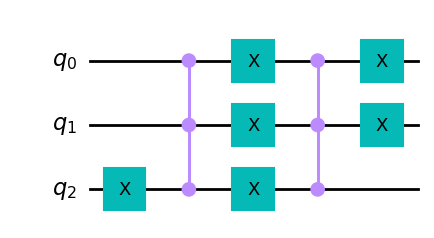

In [35]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

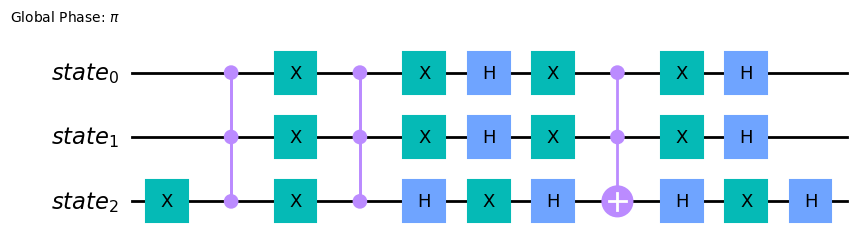

In [36]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [37]:
optimal_num_iterations = math.floor(
    math.pi / 4 * math.sqrt(2**grover_op.num_qubits / len(marked_states))
)

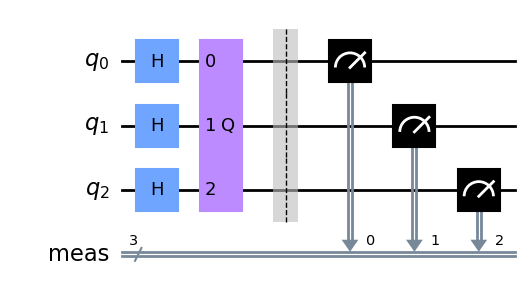

In [38]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

In [39]:
# To run on local simulator:
#   1. Use the Sampler from qiskit.primitives instead
#   2. Remove the Batch context manager below

with Session(service, backend="ibmq_qasm_simulator") as session:
    sampler = Sampler(session=session)
    dist = sampler.run(qc, shots=10000).result().quasi_dists[0]

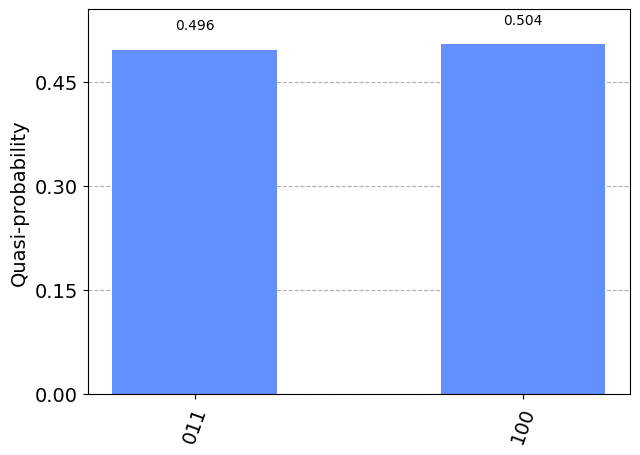

In [40]:
plot_distribution(dist.binary_probabilities())

In [41]:
with Session(service, backend=backend) as session:
    sampler = Sampler(session=session)
    dist = sampler.run(qc, shots=10000).result().quasi_dists[0]

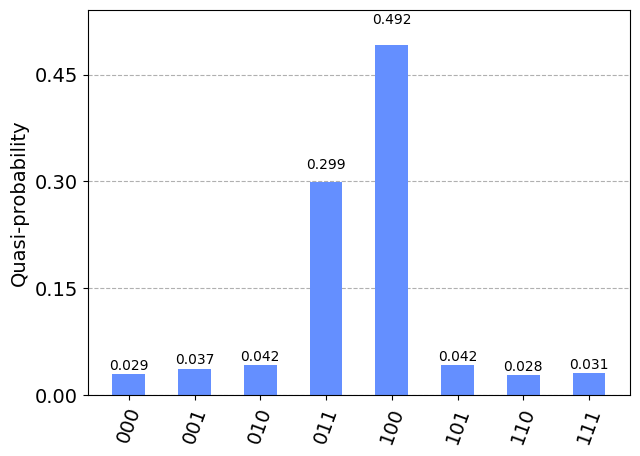

In [42]:
plot_distribution(dist.binary_probabilities())